In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sympy import *
import matplotlib.pyplot as plt
init_printing(use_latex=true)
filename = "TestData.xlsx"

In [2]:
# Establish symbols
n, T, i, t, lda, eps = symbols('n T i t \lambda \epsilon')       # n wells & T timepoints

In [3]:
# Establish number of wells
n = pd.read_excel(filename, sheet_name='n').iloc[0,0]
n

5

In [4]:
# Establish number of timepoints
T = pd.read_excel(filename, sheet_name='T').iloc[0,0]
T

41

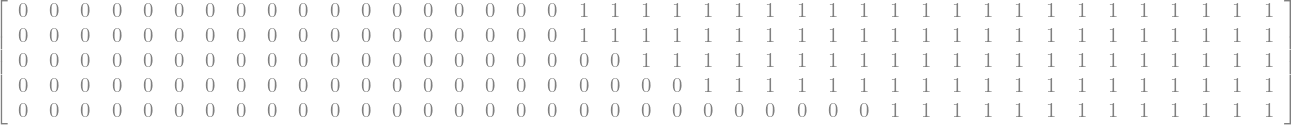

In [5]:
# Establish binary matrix for wells being on or off
z = MatrixSymbol('z', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(z.as_explicit())
zReal = Matrix(pd.read_excel(filename, sheet_name="OnOff").to_numpy().T)
zReal

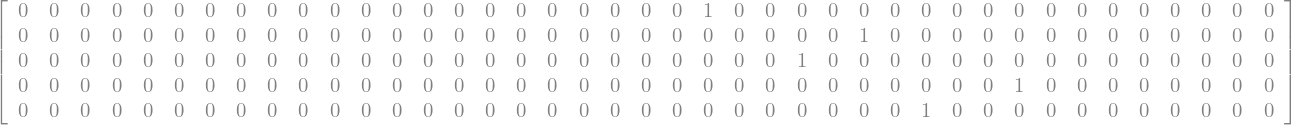

In [6]:
# Establish binary matrix for wells being measured or not
d = MatrixSymbol('d', n, T)      # Row 0 = well 0   , Column 3 = Timepoint 3
#pprint(d.as_explicit())
dReal = Matrix(pd.read_excel(filename, sheet_name="Measured").to_numpy().T)
dReal

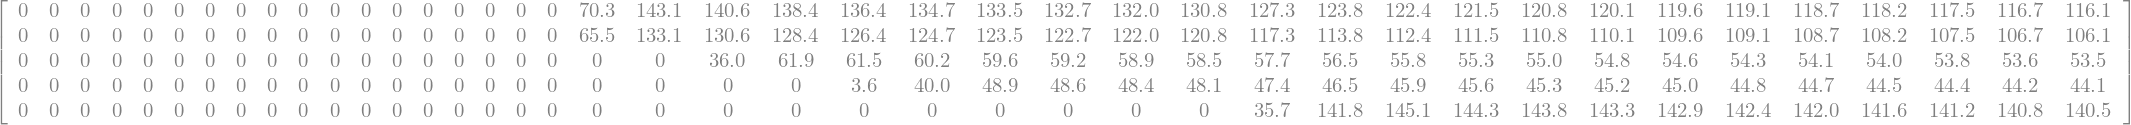

In [7]:
# Establish matrix of actual mass flows
m = MatrixSymbol('m', n, T)  
#pprint(m.as_explicit())
mReal = Matrix(pd.read_excel(filename, sheet_name="MassFlows").to_numpy().T)
mReal

In [8]:
# Establish matrix / vector of total mass flow
M = MatrixSymbol('M', 1, T)
#pprint(M.as_explicit())
MReal = Matrix(pd.read_excel(filename, sheet_name="TotalMassFlow").to_numpy().T)
MReal

In [9]:
# Establish solution vector of average mass flows per well
w = MatrixSymbol('w', n, 1)
pprint(w.as_explicit())

⎡w₀₀⎤
⎢   ⎥
⎢w₁₀⎥
⎢   ⎥
⎢w₂₀⎥
⎢   ⎥
⎢w₃₀⎥
⎢   ⎥
⎣w₄₀⎦


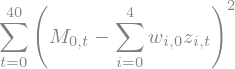

In [10]:
S1 = Sum((M[0,t] - Sum(z[i, t]*w[i,0], (i, 0, n-1)))**2 , (t, 0, T-1))
S1

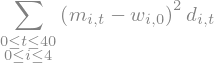

In [11]:
S2 = Sum(Sum(d[i,t]*((m[i,t]-w[i, 0]))**2 , (t, 0, T-1)), (i, 0, n-1))
S2

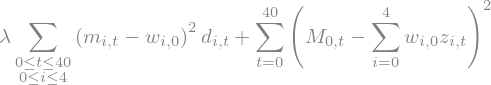

In [12]:
I = S1 + lda*S2
I

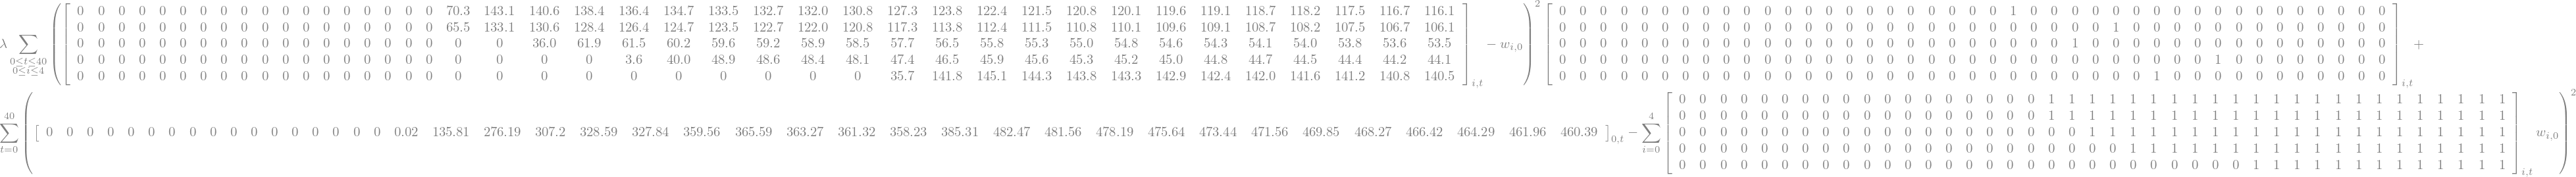

In [13]:
Inaccuracy = I.subs({M: MReal, z: zReal, d: dReal, m: mReal})
Inaccuracy

In [17]:
Inaccuracy = Inaccuracy.subs(lda, 50)

In [18]:
Inaccuracy.diff(w[4,0]).doit()

In [19]:
DiffA = np.zeros([n,n])
Diffb = np.zeros(n)
# Fill in matrix with values for Aw=b
for i in range(n):
    Diffb[i] = -1*Poly(Inaccuracy.diff(w[i,0]).doit()).coeffs()[-1]
    for j in range(n):
        DiffA[i,j] = Inaccuracy.diff(w[i,0]).doit().coeff(w[j,0])
# Then solve for w
DiffMatrixA = Matrix(DiffA)
DiffMatrixb = Matrix(Diffb)
DiffMatrixb

DiffMatrixA

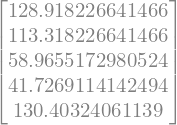

In [21]:
results = DiffMatrixA.inv()*DiffMatrixb
results

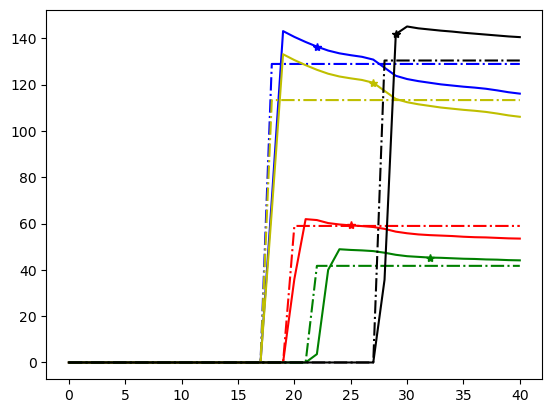

In [37]:
# Plot results from all dcwells
colours=['b', 'y', 'r', 'g', 'k']
for i in range(n):
    plt.plot(range(T),mReal[i,:][:], colours[i]+'-')
    plt.plot(range(T),np.ones(T)*results[i]*zReal[i,:][:], colours[i]+'-.')
    for month,element in enumerate(dReal[i,:]):
        if element==1:
            plt.plot(month, mReal[i,month], colours[i]+'*')



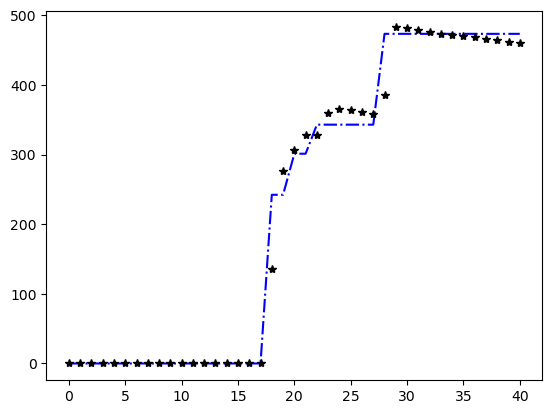

In [71]:
# Plot total flow vs found total flow
totalFlowFound = np.zeros((T,1))
times = range(T)
for t in range(T):
    tff = sum(results[i]*zReal[i,t] for i in range(n))
    #print(t, totalFlowFound)
    totalFlowFound[t] = tff

plt.plot(times,totalFlowFound, 'b-.')
plt.plot(Matrix(times).T, MReal, 'k*')

Use .diff() to get derivatives and solve for stationary points, second derivatives for minima. <----- this

Bayesian vs grid search approach for regularisation parameter tuning (MH?)

Replace flat w with linearly time-dependent w